# Data Analysis

### Imports & Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sns.set_style("whitegrid")
sns.set_context("notebook")

### Tables


In [50]:
### 1. Load Data
column_names = [
    "reference", "location", "price", "title", "bedrooms", 
    "bathrooms", "indoor_surface", "outdoor_surface", "features"
]

# Load data with flexible NA handling
df = pd.read_csv("data/properties.csv", header=None, names=column_names, na_values=["NA", "nan", ""])

In [51]:
print("--- Starting Data Cleaning & Consistency Check ---")

# --- A. Numeric Cleaning ---
# Price: Remove symbols, handle comma decimals if necessary, convert to float
df['price'] = df['price'].astype(str).str.replace('€', '').str.replace(',', '').str.strip()
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Other numeric columns
numeric_cols = ['bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- B. String Consistency (Categorical) ---
# 1. Split 'location' -> City, Region
location_split = df['location'].str.split(',', n=1, expand=True)

# Clean: Strip whitespace and Title Case for consistency (e.g., " marbella" -> "Marbella")
df['city'] = location_split[0].str.strip().str.title()
df['region'] = location_split[1].str.strip().str.title()

# 2. Split 'title' -> Property Type
# Regex: Remove leading numbers and "Bedroom/s" to isolate the type (e.g., "3 Bedroom Villa" -> "Villa")
df['property_type'] = df['title'].astype(str).str.replace(r'^\d+\s*Bedrooms?\s*', '', regex=True)
# Clean: Strip, Title Case, and remove generic fillers like "For Sale" if present
df['property_type'] = df['property_type'].str.replace('For Sale', '').str.strip().str.title()

# (Optional helper for integrity check)
df['bedrooms_from_title'] = df['title'].astype(str).str.extract(r'^(\d+)\s*Bedroom').astype(float)

# --- C. Binary Features (True/False) ---
df['features'] = df['features'].fillna('')
# Create dummies
feature_dummies = df['features'].str.get_dummies(sep='|')

# Clean Column Names: snake_case (lowercase, underscores)
feature_dummies.columns = feature_dummies.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert 0/1 to Boolean (True/False)
feature_dummies = feature_dummies.astype(bool)

# Concatenate back
df = pd.concat([df, feature_dummies], axis=1)

# Remove duplicates created during merge
df = df.loc[:, ~df.columns.duplicated()]

--- Starting Data Cleaning & Consistency Check ---


In [52]:
# --- D. Define Variable Groups ---
# Continuous
continuousFeatures = ["price", "bedrooms", "bathrooms", "indoor_surface", "outdoor_surface"]

# Categorical (Main)
categoricalFeatures = ["city", "region", "property_type"]

# Binary (Boolean)
binaryFeatures = feature_dummies.columns.tolist()

# Total Categorical (Main + Boolean) for analysis
allCategoricalFeatures = categoricalFeatures + binaryFeatures

print("Data Cleaning Complete.")
display(df.head())

Data Cleaning Complete.


,reference,location,price,title,bedrooms,bathrooms,indoor_surface,outdoor_surface,features,city,...,u/f_heating_climate_control,underground_parking,urban_views,urbanisation,utility_room,village,west_orientation,wifi,with_planning_permission,wood_flooring
0,R126116,"Nueva Andalucía, Costa del Sol",450000,3 Bedroom Apartment,3.0,2.0,120.0,NaN,Close to Shops|Electricity Utilities|Close to ...,Nueva Andalucía,...,False,False,False,True,False,False,False,False,False,False
1,R132516,"Puerto Banús, Costa del Sol",1250000,Other,1.0,504.0,NaN,NaN,Electricity Utilities|Close to Town|Street Vie...,Puerto Banús,...,False,True,False,False,False,False,True,False,False,False
2,R121563,"Antequera, Costa del Sol",749000,12 Bedroom Finca,12.0,7.0,366.0,5353.0,Mountain Views|Private Garden|Open Parking|Urb...,Antequera,...,False,False,True,False,False,False,False,False,False,False
3,R127293,"La Mairena, Costa del Sol",500000,Plot,3470.0,NaN,NaN,NaN,Mountain Views|Private Garden|Electricity Util...,La Mairena,...,False,False,False,True,False,False,False,False,True,False
4,R114041,"Benalmadena, Costa del Sol",1695000,4 Bedroom Detached Villa,4.0,4.0,634.0,1000.0,Private Garden|Electricity Utilities|Drinkable...,Benalmadena,...,False,False,False,False,False,False,False,False,False,False


In [61]:
display(allCategoricalFeatures)
display(continuousFeatures)

['city',
 'region',
 'property_type',
 'access_for_people_with_reduced_mobility',
 'air_conditioning_climate_control',
 'alarm_system_security',
 'bar',
 'barbeque',
 'bargain',
 'basement',
 'beach_views',
 'beachfront',
 'beachside',
 'car_hire_facility',
 'central_heating_climate_control',
 'cheap',
 'children`s_pool_pool',
 'close_to_forest',
 'close_to_marina',
 'close_to_sea',
 'close_to_skiing',
 'close_to_golf',
 'close_to_schools',
 'close_to_shops',
 'close_to_town',
 'close_to_port',
 'cold_a/c_climate_control',
 'commercial_area',
 'communal_garden',
 'communal_parking',
 'communal_pool',
 'contemporary',
 'country',
 'country_views',
 'courtesy_bus',
 'courtyard_views',
 'covered_parking',
 'covered_terrace',
 'day_care',
 'distressed',
 'domotics',
 'double_glazing',
 'drinkable_water_utilities',
 'east_orientation',
 'easy_maintenance_garden',
 'electric_blinds_security',
 'electricity_utilities',
 'ensuite_bathroom',
 'entry_phone_security',
 'excellent_condition',
 'fa

['price', 'bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']

### Continuous Summary

In [62]:
continuous_summary = df[continuousFeatures].describe(include='all').T
continuous_summary['cardinality'] = df[continuousFeatures].nunique()
continuous_summary['missing_%'] = (df[continuousFeatures].isnull().sum() / len(df)) * 100

continuous_summary = continuous_summary.rename(columns={
    'count': 'total_number_of_values',
    '25%': '1st_quartile',
    '50%': 'median',
    '75%': '3rd_quartile',
    'min': 'minimum',
    'max': 'maximum',
    'std': 'standard_deviation'
})

display(continuous_summary)

,total_number_of_values,mean,standard_deviation,minimum,1st_quartile,median,3rd_quartile,maximum,cardinality,missing_%
price,12086.0,1.046977e+06,1.881298e+06,4500.0,285000.0,475000.0,995000.00,50000000.0,1717,0.000000
bedrooms,12084.0,2.533518e+03,9.853142e+04,0.0,2.0,3.0,5.00,9700000.0,904,0.016548
bathrooms,10952.0,1.076485e+03,4.636483e+04,0.0,2.0,2.0,4.00,4630000.0,453,9.382757
indoor_surface,10414.0,2.334892e+02,2.650649e+02,10.0,100.0,144.5,268.75,5367.0,923,13.834188
outdoor_surface,3821.0,1.113215e+04,1.960650e+05,1.0,401.0,1009.0,2342.00,9350000.0,1797,68.384908


### Categorical Summary

In [63]:
print("\n--- Nominal Categorical Summary ---")
categorical_summary_list = []
for feature in categoricalFeatures:
    if feature in df.columns:
        total_values = df[feature].count()
        value_counts = df[feature].value_counts()
        
        mode_1 = value_counts.index[0] if not value_counts.empty else 'N/A'
        mode_1_freq = value_counts.iloc[0] if not value_counts.empty else 0
        mode_1_perc = (mode_1_freq / total_values) * 100 if total_values > 0 else 0
        
        categorical_summary_list.append({
            'feature': feature, 
            'unique_values': df[feature].nunique(),
            'missing_%': (df[feature].isnull().sum() / len(df)) * 100,
            'mode': mode_1, 
            'mode_%': round(mode_1_perc, 2)
        })

display(pd.DataFrame(categorical_summary_list).set_index('feature'))


--- Nominal Categorical Summary ---


,unique_values,missing_%,mode,mode_%
feature,,,,
city,226,0.0,Estepona,8.79
region,2,0.0,Costa Del Sol,99.22
property_type,39,0.0,Apartment,32.83


In [64]:
# --- C. Binary/Boolean Analysis (Categorical) ---
print("\n--- Boolean Categorical Analysis (Features) ---")

# Calculate frequency of True values (Prevalence)
# Since they are booleans, sum() gives the count of Trues
binary_counts = df[binaryFeatures].sum().sort_values(ascending=False)
binary_prevalence = (binary_counts / len(df)) * 100

# Create a summary table for Binary Data
binary_summary = pd.DataFrame({
    'count_true': binary_counts,
    'prevalence_%': binary_prevalence
})

print("Top 10 Most Common Boolean Features:")
display(binary_summary.head(10))


--- Boolean Categorical Analysis (Features) ---
Top 10 Most Common Boolean Features:


,count_true,prevalence_%
fully_fitted_kitchen,8619,71.313917
private_terrace,8183,67.706437
air_conditioning_climate_control,7902,65.381433
fitted_wardrobes,7530,62.303492
close_to_shops,6384,52.821446
covered_terrace,6221,51.472778
electricity_utilities,5942,49.164322
close_to_schools,5840,48.320371
excellent_condition,5825,48.196260
communal_pool,5553,45.945722


In [65]:
categorical_summary_list = []
for feature in allCategoricalFeatures:
    total_values = df[feature].count()
    missing_percentage = (df[feature].isnull().sum() / len(df)) * 100
    cardinality = df[feature].nunique()
    value_counts = df[feature].value_counts()
    
    mode_1 = value_counts.index[0] if not value_counts.empty else 'N/A'
    mode_1_freq = value_counts.iloc[0] if not value_counts.empty else 0
    mode_1_perc = (mode_1_freq / total_values) * 100 if total_values > 0 else 0
    
    mode_2 = value_counts.index[1] if cardinality > 1 else 'N/A'
    
    categorical_summary_list.append({
        'feature': feature, 'count': total_values, 'missing_%': missing_percentage,
        'cardinality': cardinality, 'mode': mode_1, 'mode_freq': mode_1_freq, 'mode_%': mode_1_perc,
        'mode_2': mode_2
    })

categorical_summary = pd.DataFrame(categorical_summary_list).set_index('feature')
display(categorical_summary)

,count,missing_%,cardinality,mode,mode_freq,mode_%,mode_2
feature,,,,,,,
city,12086,0.0,226,Estepona,1062,8.787026,Nueva Andalucía
region,12086,0.0,2,Costa Del Sol,11992,99.222241,Málaga Ciudad
property_type,12086,0.0,39,Apartment,3968,32.831375,Detached Villa
access_for_people_with_reduced_mobility,12086,0.0,2,False,10851,89.781565,True
air_conditioning_climate_control,12086,0.0,2,True,7902,65.381433,False
...,...,...,...,...,...,...,...
village,12086,0.0,2,False,11161,92.346517,True
west_orientation,12086,0.0,2,False,10214,84.511004,True
wifi,12086,0.0,2,False,9129,75.533675,True


### Binary Data Summary

In [66]:
# ==========================================
# 4. Binary Data Analysis
# ==========================================
print("\n--- Binary (Feature) Data Analysis ---")

# 1. Prevalence (Frequency)
# Calculate percentage of properties holding each feature
feature_prevalence = df[binaryFeatures].mean() * 100
feature_prevalence = feature_prevalence.sort_values(ascending=False)

# 2. Correlation with Price (Premium Analysis)
# We calculate the correlation of every binary feature with the Price column
feature_price_corr = df[binaryFeatures].apply(lambda x: x.corr(df['price']))
feature_price_corr = feature_price_corr.sort_values(ascending=False)

# Combine into a summary dataframe
binary_analysis = pd.DataFrame({
    'prevalence_%': feature_prevalence,
    'price_correlation': feature_price_corr
})

print("Top 10 Most Common Features:")
display(binary_analysis.sort_values('prevalence_%', ascending=False).head(10))

print("Top 10 Features most positively correlated with Price:")
display(binary_analysis.sort_values('price_correlation', ascending=False).head(10))


--- Binary (Feature) Data Analysis ---
Top 10 Most Common Features:


,prevalence_%,price_correlation
fully_fitted_kitchen,71.313917,0.015476
private_terrace,67.706437,0.007185
air_conditioning_climate_control,65.381433,0.034134
fitted_wardrobes,62.303492,0.005949
close_to_shops,52.821446,-0.037838
covered_terrace,51.472778,0.078226
electricity_utilities,49.164322,-0.109980
close_to_schools,48.320371,0.018604
excellent_condition,48.196260,0.072979
communal_pool,45.945722,-0.219316


Top 10 Features most positively correlated with Price:


,prevalence_%,price_correlation
private_pool,23.854046,0.362514
private_garden,30.928347,0.267218
games_room,5.030614,0.262251
u/f_heating_climate_control,8.083733,0.257355
luxury,23.920238,0.243831
jacuzzi,8.447791,0.211763
gym,12.229025,0.199654
alarm_system_security,18.153235,0.199026
domotics,4.401787,0.193423
sauna,6.668873,0.173556


### Data Issues

In [69]:
# --- 1. Check for Missing Values ---
print("--- 1. Missing Values Check ---")
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_values, missing_percentage], axis=1)
missing_table = missing_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

# Filter to show only columns with missing values
missing_table = missing_table[missing_table.iloc[:,0] != 0]

if missing_table.empty:
    print("Congratulations! No missing values found.\n")
else:
    print("Found missing values in the following columns (Top 10):")
    display(missing_table.sort_values('% of Total Values', ascending=False).head(10).round(2))

--- 1. Missing Values Check ---
Found missing values in the following columns (Top 10):


,Missing Values,% of Total Values
outdoor_surface,8265,68.38
bedrooms_from_title,1711,14.16
indoor_surface,1672,13.83
bathrooms,1134,9.38
bedrooms,2,0.02


In [70]:
# --- 2. Check for Duplicate Rows ---
print("\n--- 2. Duplicate Rows Check ---")
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"Found {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found.\n")


--- 2. Duplicate Rows Check ---
Found 61 duplicate rows in the dataset.


In [71]:
# --- 3. Check for Constant or Quasi-Constant Columns ---
print("\n--- 3. Constant Columns Check ---")
# Columns with only one unique value (or 0 variance) provide no info
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print(f"The following columns have only 1 unique value (constant): {constant_cols[:5]} ... (Total: {len(constant_cols)})")
else:
    print("No constant columns found.")


--- 3. Constant Columns Check ---
No constant columns found.


In [89]:
# --- 4. Categorical Data Quality Audit ---
print("\n" + "="*40)
print("   CATEGORICAL DATA QUALITY REPORT")
print("="*40 + "\n")

quality_metrics = []

for col in categoricalFeatures:
    if col not in df.columns: continue
    
    # --- 1. Calculate Metrics ---
    
    # Consistency Check (Raw vs Cleaned)
    raw_uniques = df[col].nunique()
    # We simulate cleaning to check if the count drops (implying duplicates like "Villa" vs "villa ")
    clean_series = df[col].astype(str).str.strip().str.title()
    clean_uniques = clean_series.nunique()
    is_inconsistent = raw_uniques != clean_uniques
    
    # Rare Labels (Potential Typos)
    val_counts = df[col].value_counts()
    rare_count = (val_counts < 2).sum()
    
    # Class Imbalance
    if not val_counts.empty:
        top_cat_name = val_counts.index[0]
        top_cat_perc = (val_counts.iloc[0] / len(df)) * 100
        is_imbalanced = top_cat_perc > 80
    else:
        top_cat_name = "N/A"
        top_cat_perc = 0
        is_imbalanced = False

    # --- 2. Store Metrics for Summary Table ---
    quality_metrics.append({
        'Feature': col,
        'Unique Values': raw_uniques,
        'Inconsistent Formatting': "DETECTED" if is_inconsistent else "Clean",
        'Rare Labels (<2)': rare_count,
        'Dominant Class %': round(top_cat_perc, 1),
        'Imbalance Status': "HIGH Warning" if is_imbalanced else "Acceptable"
    })

    # --- 3. Print Details ONLY if Issues Found (Exception Reporting) ---
    if is_inconsistent or is_imbalanced or (rare_count > 0):
        print(f"⚠️  ISSUES FOUND IN '{col}':")
        
        if is_inconsistent:
            diff = raw_uniques - clean_uniques
            print(f"   • Formatting: Found {diff} potential duplicates due to casing/whitespace.")
            # Show example of the messiness
            example = df[col][df[col] != clean_series].unique()[:3]
            print(f"     Example inconsistencies: {example}")
            
        if rare_count > 0:
            print(f"   • Typos: {rare_count} categories appear only once (rare labels).")
            
        if is_imbalanced:
            print(f"   • Imbalance: '{top_cat_name}' dominates {top_cat_perc:.1f}% of the dataset.")
            
        print("-" * 30)

# --- 4. Display Clean Summary Table ---
print("\nSummary Overview:")
quality_df = pd.DataFrame(quality_metrics).set_index('Feature')

# Highlight "DETECTED" or "HIGH Warning" if possible, otherwise just display
display(quality_df)


   CATEGORICAL DATA QUALITY REPORT

⚠️  ISSUES FOUND IN 'city':
   • Typos: 34 categories appear only once (rare labels).
------------------------------
⚠️  ISSUES FOUND IN 'region':
   • Imbalance: 'Costa Del Sol' dominates 99.2% of the dataset.
------------------------------
⚠️  ISSUES FOUND IN 'property_type':
   • Typos: 3 categories appear only once (rare labels).
------------------------------

Summary Overview:


,Unique Values,Inconsistent Formatting,Rare Labels (<2),Dominant Class %,Imbalance Status
Feature,,,,,
city,226,Clean,34,8.8,Acceptable
region,2,Clean,0,99.2,HIGH Warning
property_type,39,Clean,3,32.8,Acceptable


In [75]:
# --- 5. Data Integrity: Bedrooms vs Title ---
# Check if "3 Bedroom Apartment" actually has 3 in the bedrooms column
print("\n--- 5. Data Integrity: Title vs Bedroom Column ---")
# Compare where both are not NaN
integrity_check = df.dropna(subset=['bedrooms', 'bedrooms_from_title'])
mismatches = integrity_check[integrity_check['bedrooms'] != integrity_check['bedrooms_from_title']]

if not mismatches.empty:
    print(f"[!] Found {len(mismatches)} rows where 'bedrooms' column does not match the title description.")
    print("Example mismatches:")
    display(mismatches[['title', 'bedrooms', 'bedrooms_from_title']].head())
else:
    print("Bedroom counts in Title and Column match perfectly.")



--- 5. Data Integrity: Title vs Bedroom Column ---
Bedroom counts in Title and Column match perfectly.


In [ ]:
# --- 5. Numerical Validity & Skewness ---
print("\n--- 5. Numerical Logic & Distribution ---")

# A. Negative Values Check
print("Checking for illogical negative values...")
impossible_negatives = ['price', 'indoor_surface', 'outdoor_surface', 'bedrooms', 'bathrooms']
for col in impossible_negatives:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            print(f"  [!] Warning: '{col}' has {neg_count} negative values.")
        else:
            print(f"  '{col}' is clean (no negatives).")

# B. Skewness Check
print("\nChecking Skewness (Threshold: > 1 or < -1)...")
skewness = df[continuousFeatures].skew()
high_skew = skewness[abs(skewness) > 1]
if not high_skew.empty:
    print("The following variables are highly skewed (indicating potential outliers):")
    print(high_skew)
else:
    print("No highly skewed variables found.")


--- 5. Numerical Logic & Distribution ---
Checking for illogical negative values...
  'price' is clean (no negatives).
  'indoor_surface' is clean (no negatives).
  'outdoor_surface' is clean (no negatives).
  'bedrooms' is clean (no negatives).
  'bathrooms' is clean (no negatives).

Checking Skewness (Threshold: > 1 or < -1)...
The following variables are highly skewed (indicating potential outliers):
price               7.670615
bedrooms           83.166552
bathrooms          92.041640
indoor_surface      5.708034
outdoor_surface    36.865489
dtype: float64



--- 6. Outlier Detection (IQR Method) ---
Outliers found in 'price': 1375 (11.4%)
Outliers found in 'bedrooms': 1557 (12.9%)
Outliers found in 'bathrooms': 755 (6.9%)
Outliers found in 'indoor_surface': 932 (8.9%)
Outliers found in 'outdoor_surface': 466 (12.2%)

Generating boxplots for visual confirmation...


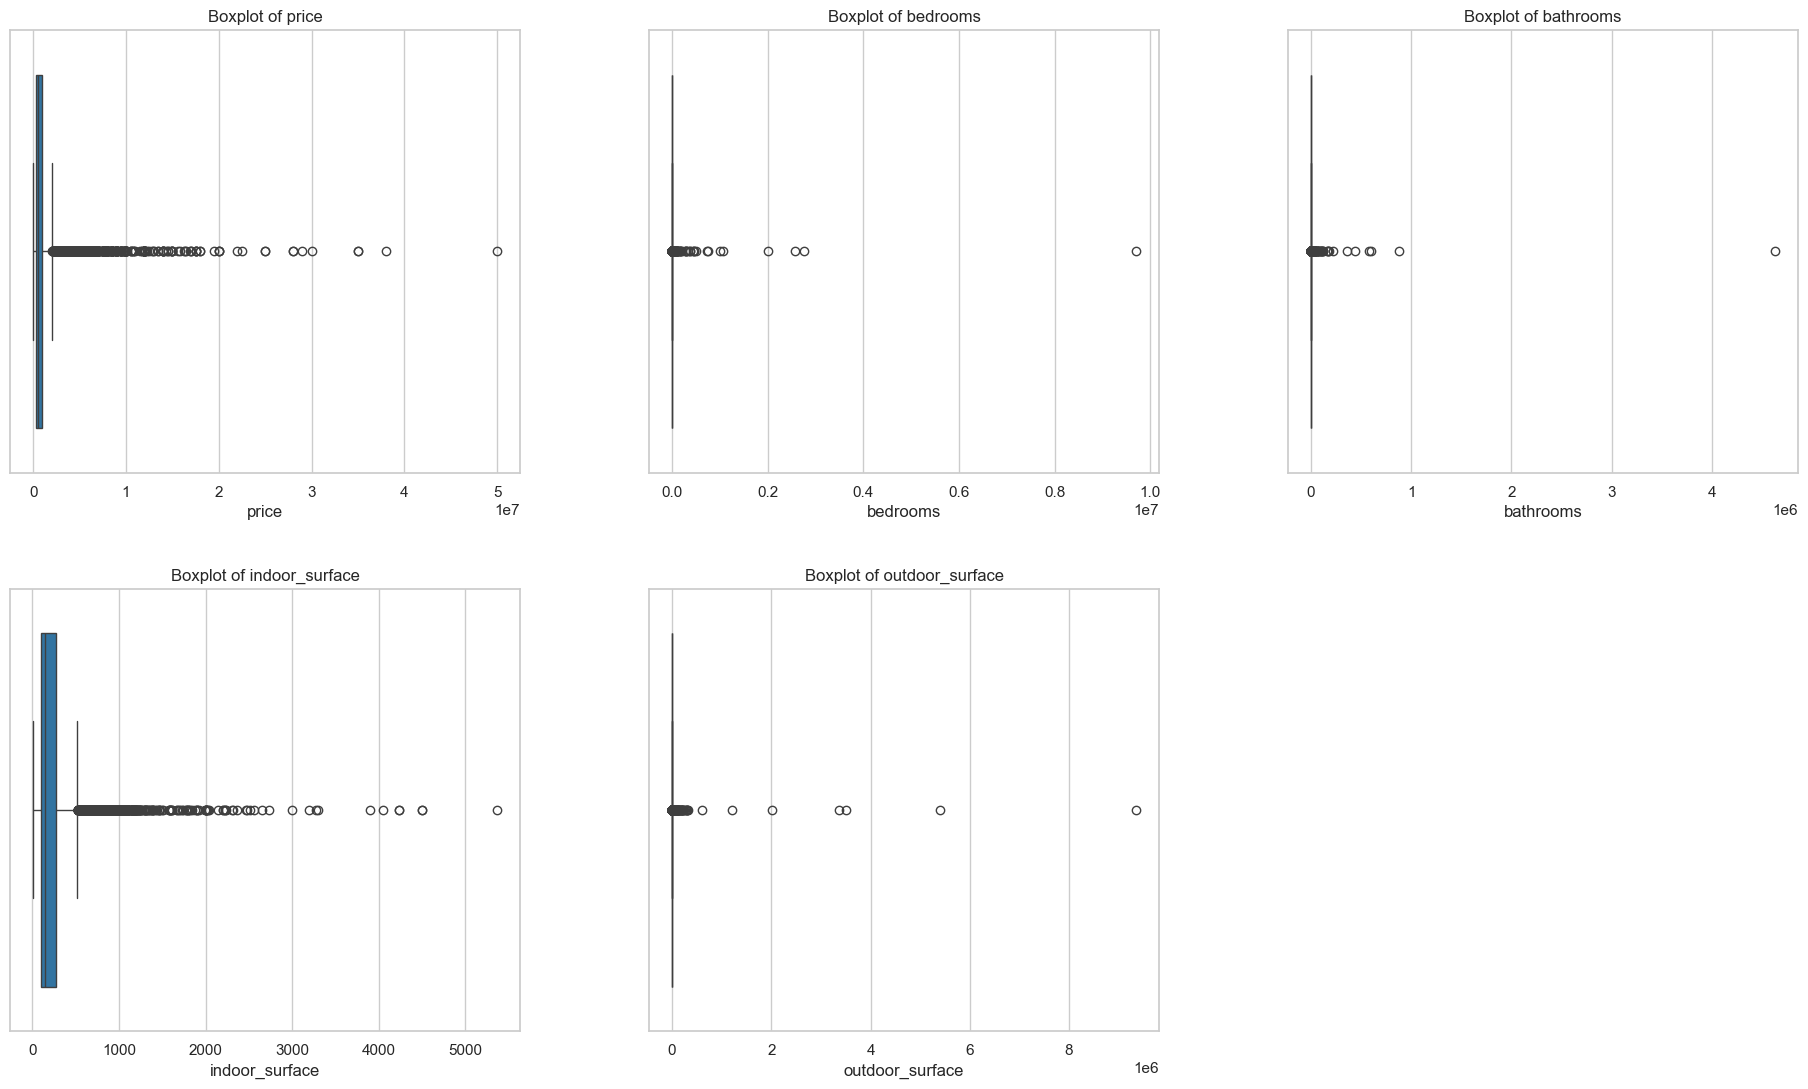

In [77]:
# --- 6. Outlier Detection (IQR) ---
print("\n--- 6. Outlier Detection (IQR Method) ---")
for col in continuousFeatures:
    valid_data = df[col].dropna()
    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]
    
    if not outliers.empty:
        print(f"Outliers found in '{col}': {len(outliers)} ({len(outliers)/len(valid_data)*100:.1f}%)")
    else:
        print(f"No outliers found in '{col}'.")

print("\nGenerating boxplots for visual confirmation...")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = axes.flatten()
for i in range(len(continuousFeatures)):
    col = continuousFeatures[i]
    sns.boxplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f"Boxplot of {col}")

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig('images/boxplots.pdf')
plt.show()

### Histograms

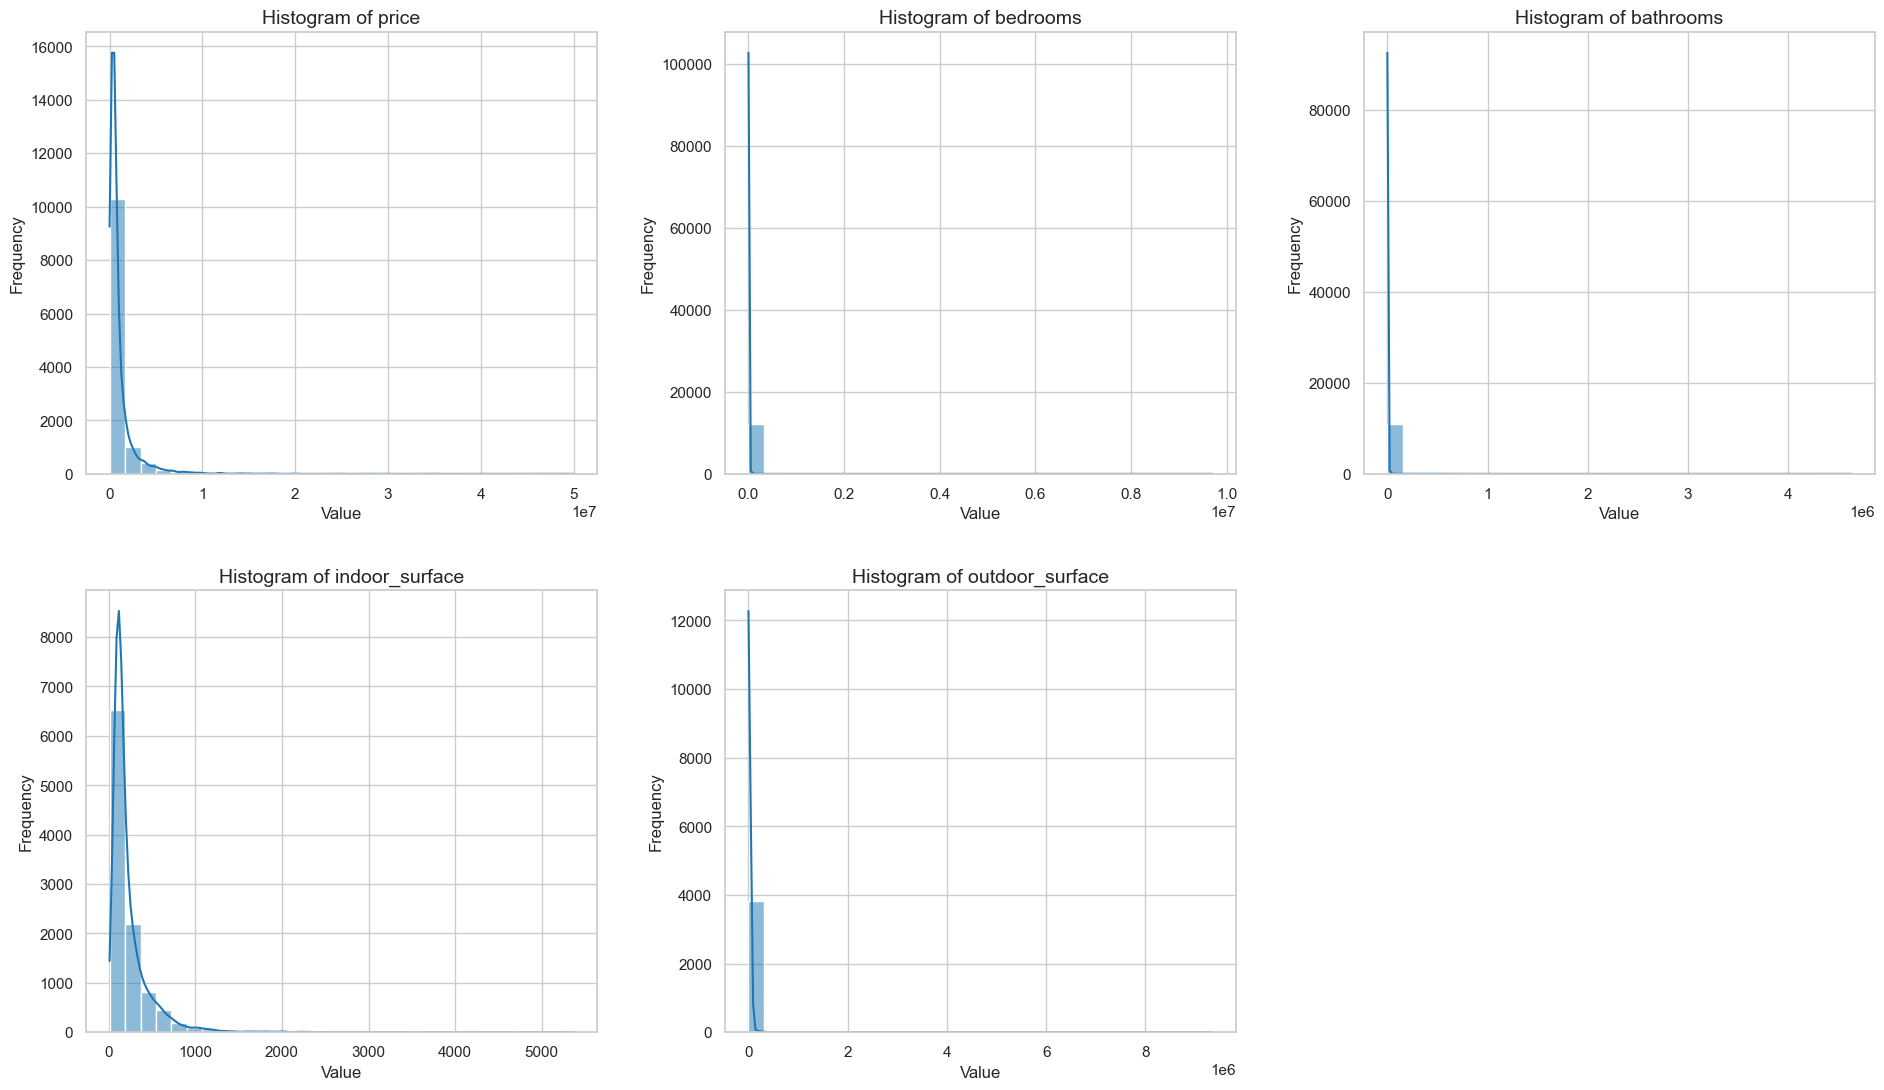

In [78]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = ax.flatten()

for i in range(len(continuousFeatures)):
    current_feature = continuousFeatures[i]
    sns.histplot(data=df, x=current_feature, bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f'Histogram of {current_feature}', fontsize=14)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig("images/histograms.pdf")
plt.show()

### Plot Relationships


Generating scatter plot for Indoor Surface vs. Price...


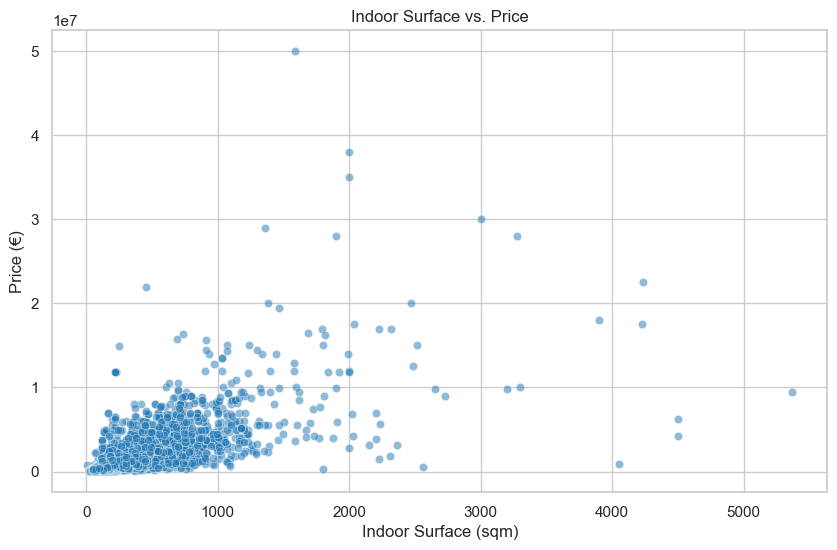


Generating box plot for Price vs Bedrooms...


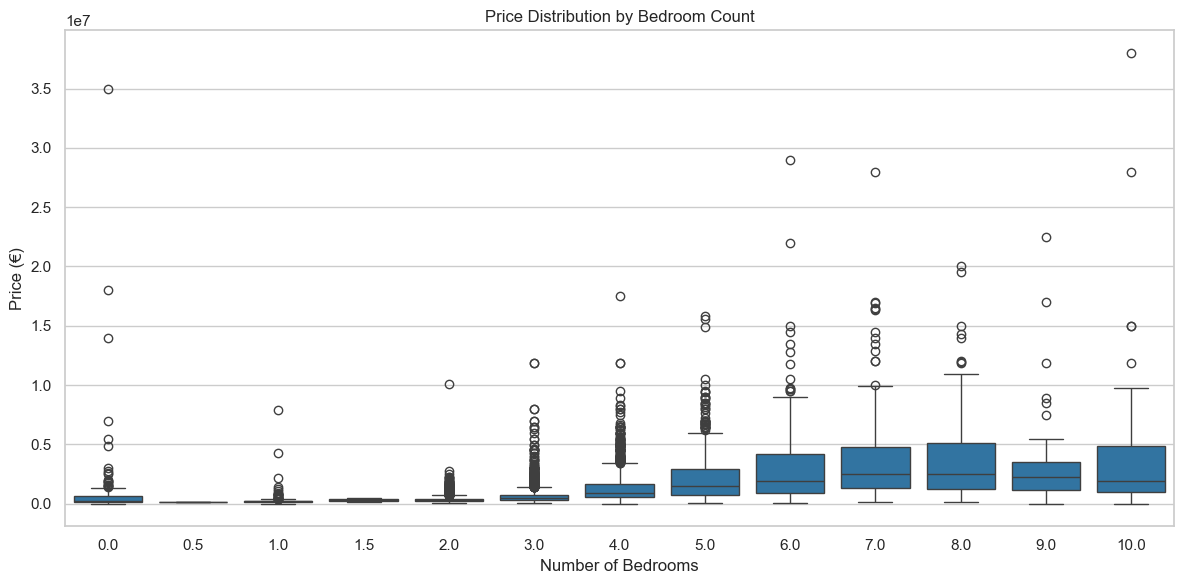


Generating Price vs Property Type...


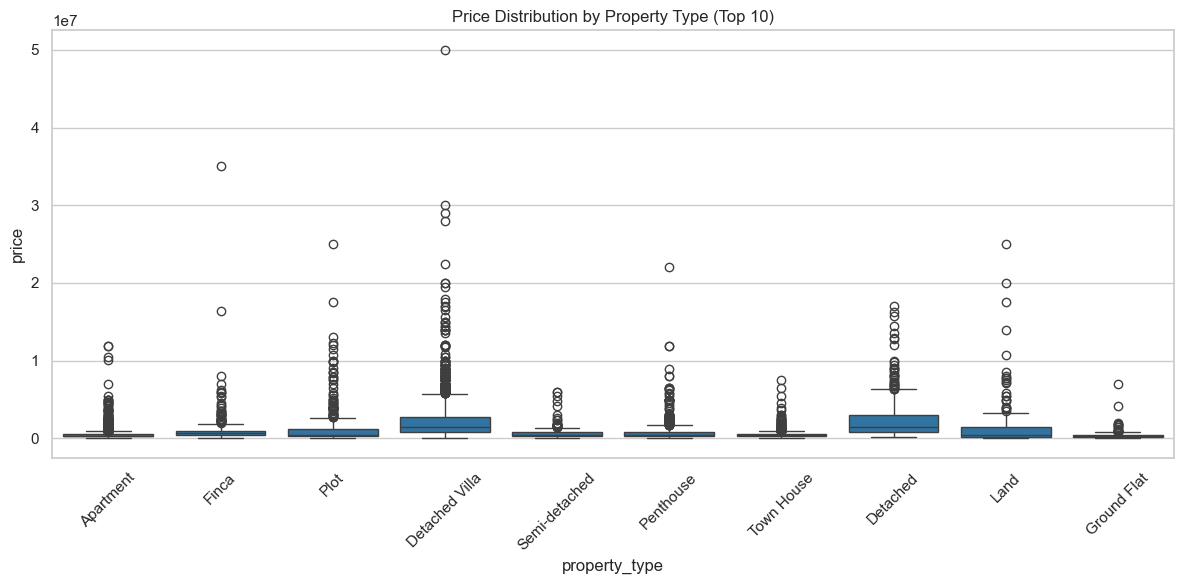


Generating Top Cities bar plot...


/tmp/ipykernel_45039/3711184661.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city', data=df, order=top_cities, palette='viridis')


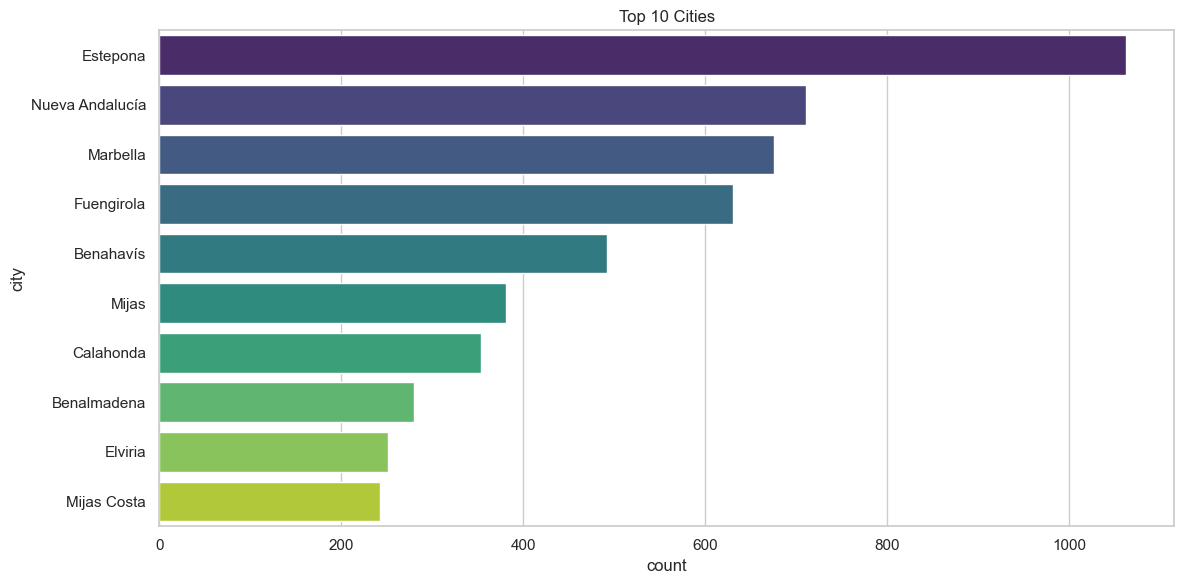


Generating Top Features bar plot...


/tmp/ipykernel_45039/3711184661.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_sums.values, y=feature_sums.index, palette='viridis')


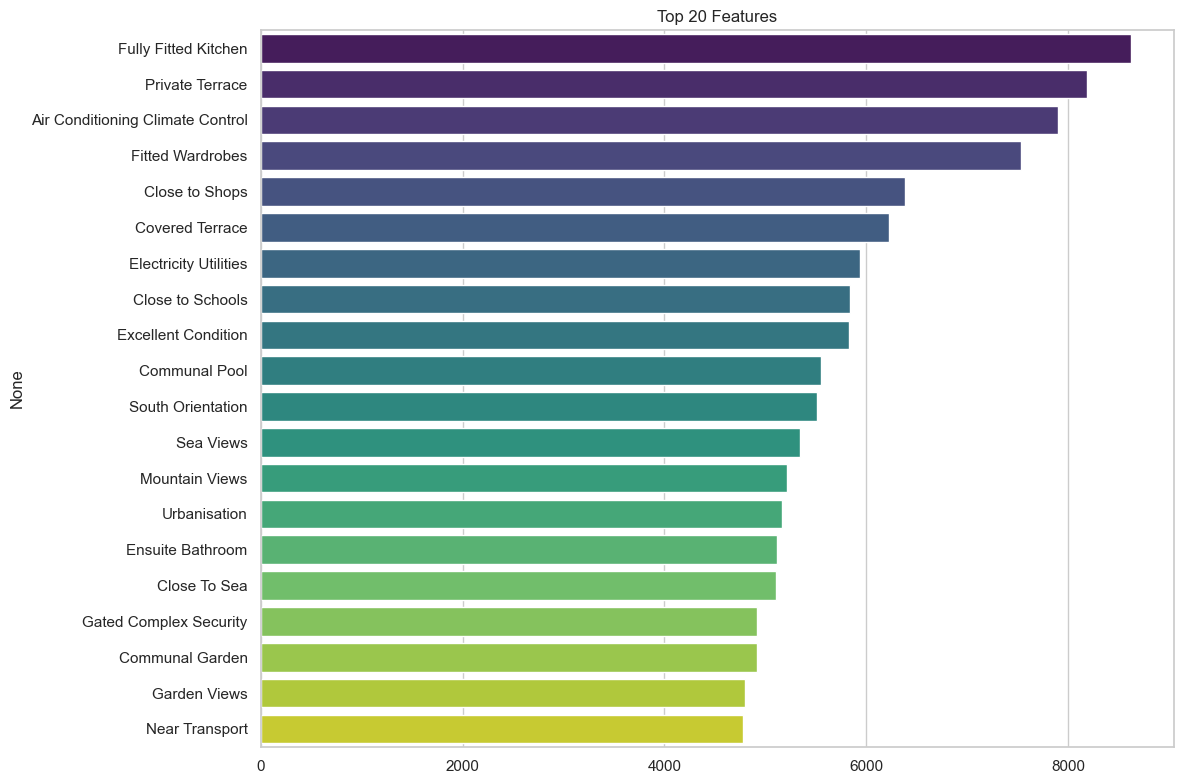


Generating bar plot for Top 10 Locations...


/tmp/ipykernel_45039/3711184661.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='location', data=df, order=top_locations, palette='viridis')


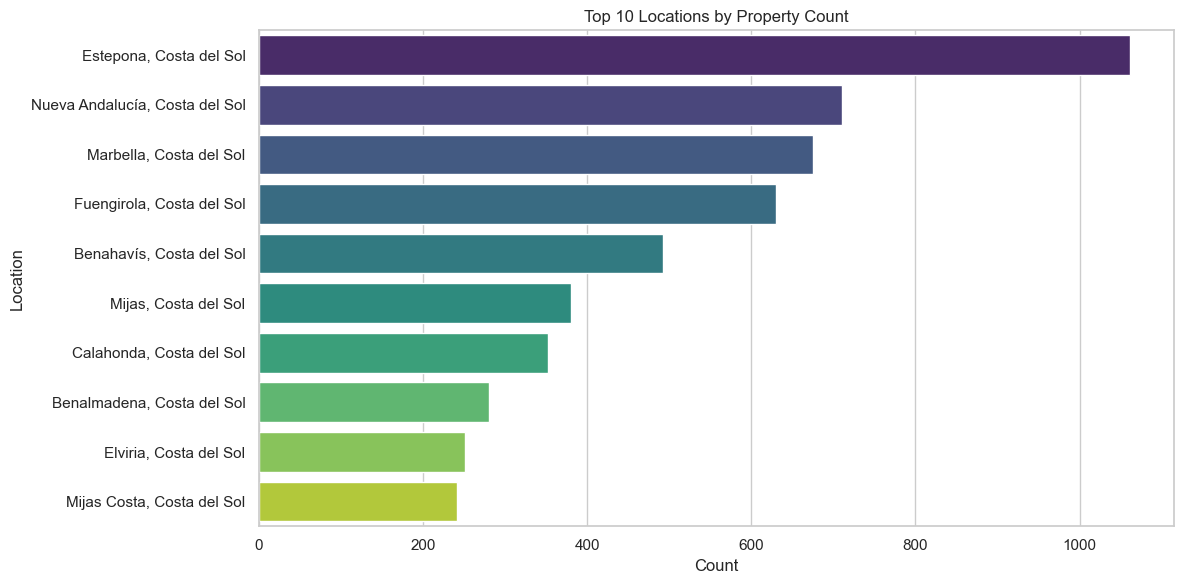


Generating bar plot for Top 20 Property Features...


/tmp/ipykernel_45039/3711184661.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.values, y=feature_counts.index, palette='viridis')


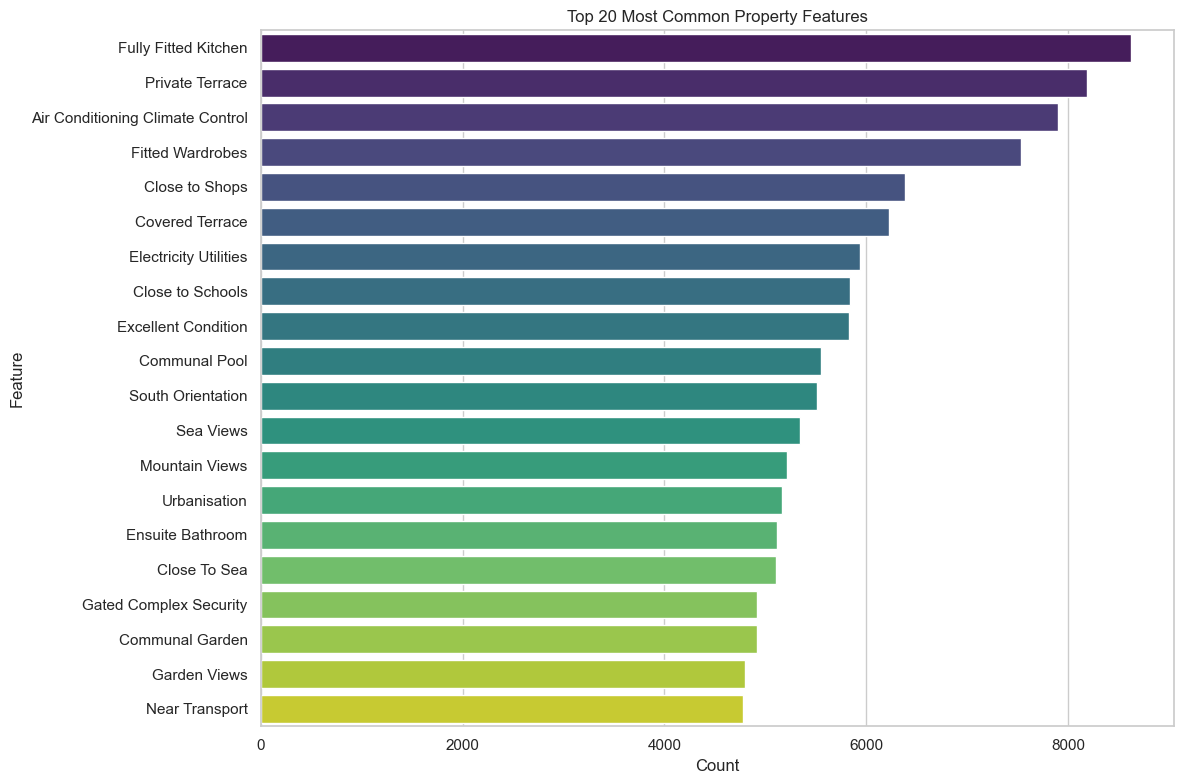

In [ ]:
# Scatter Plot: Indoor Surface vs Price
print("\nGenerating scatter plot for Indoor Surface vs. Price...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='indoor_surface', y='price', alpha=0.5)
plt.xlabel('Indoor Surface (sqm)')
plt.ylabel('Price (€)')
plt.title('Indoor Surface vs. Price')
plt.savefig('images/scatter_surface_price.pdf')
plt.show()

# Box Plot: Price vs Bedrooms
print("\nGenerating box plot for Price vs Bedrooms...")
plt.figure(figsize=(12, 6))
# Filter to reasonable bedroom counts (e.g., <= 10) to keep plot readable
subset_df = df[df['bedrooms'] <= 10]
sns.boxplot(x='bedrooms', y='price', data=subset_df)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (€)')
plt.title('Price Distribution by Bedroom Count')
plt.tight_layout()
plt.savefig('images/price_vs_bedrooms.pdf')
plt.show()


# 1. Price vs Property Type 
print("\nGenerating Price vs Property Type...")
plt.figure(figsize=(12, 6))
# Filter to top 10 property types for readability
top_types = df['property_type'].value_counts().nlargest(10).index
sns.boxplot(x='property_type', y='price', data=df[df['property_type'].isin(top_types)])
plt.xticks(rotation=45)
plt.title('Price Distribution by Property Type (Top 10)')
plt.tight_layout()
plt.savefig('images/price_vs_property_type.pdf')
plt.show()

# 2. Top Cities 
print("\nGenerating Top Cities bar plot...")
plt.figure(figsize=(12, 6))
top_cities = df['city'].value_counts().nlargest(10).index
sns.countplot(y='city', data=df, order=top_cities, palette='viridis')
plt.title('Top 10 Cities')
plt.tight_layout()
plt.savefig('images/top_cities.pdf')
plt.show()

# 3. Top Features
print("\nGenerating Top Features bar plot...")
# Calculate sum of binary features
feature_sums = df[binaryFeatures].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_sums.values, y=feature_sums.index, palette='viridis')
plt.title('Top 20 Features')
plt.tight_layout()
plt.savefig('images/top_features.pdf')
plt.show()

# Bar Plot: Top 10 Locations
print("\nGenerating bar plot for Top 10 Locations...")
top_locations = df['location'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.countplot(y='location', data=df, order=top_locations, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Top 10 Locations by Property Count')
plt.tight_layout()
plt.savefig('images/top_locations.pdf')
plt.show()

# Bar Plot: Top 20 Features (New!)
print("\nGenerating bar plot for Top 20 Property Features...")
# Sum the binary columns to get counts of each feature
feature_counts = df[binaryFeatures].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_counts.values, y=feature_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.title('Top 20 Most Common Property Features')
plt.tight_layout()
plt.savefig('images/top_features.pdf')
plt.show()

### Pair Plots

Generating pairplot for all continuous variables...


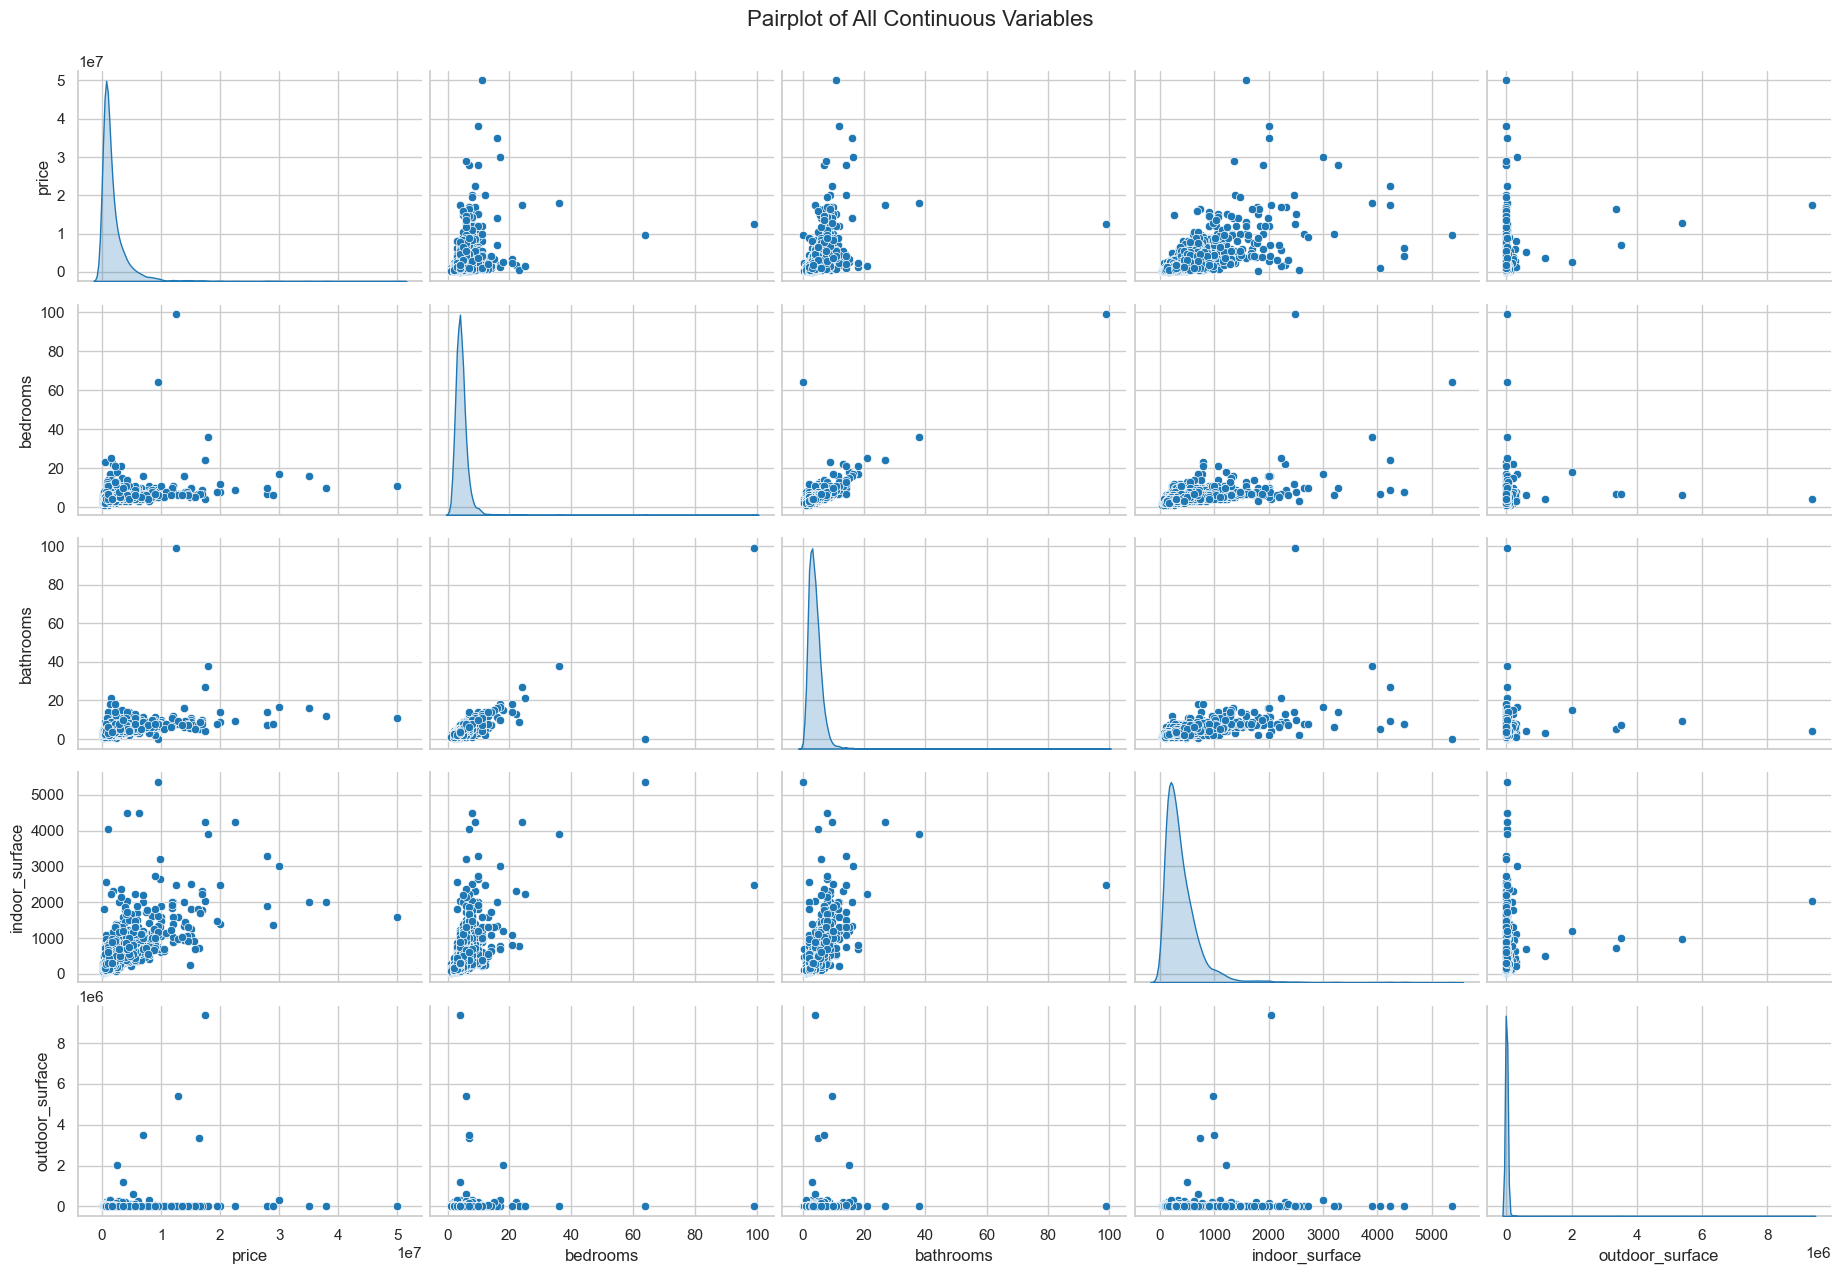


Generating Count Plots for Main Categories...


/tmp/ipykernel_45039/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


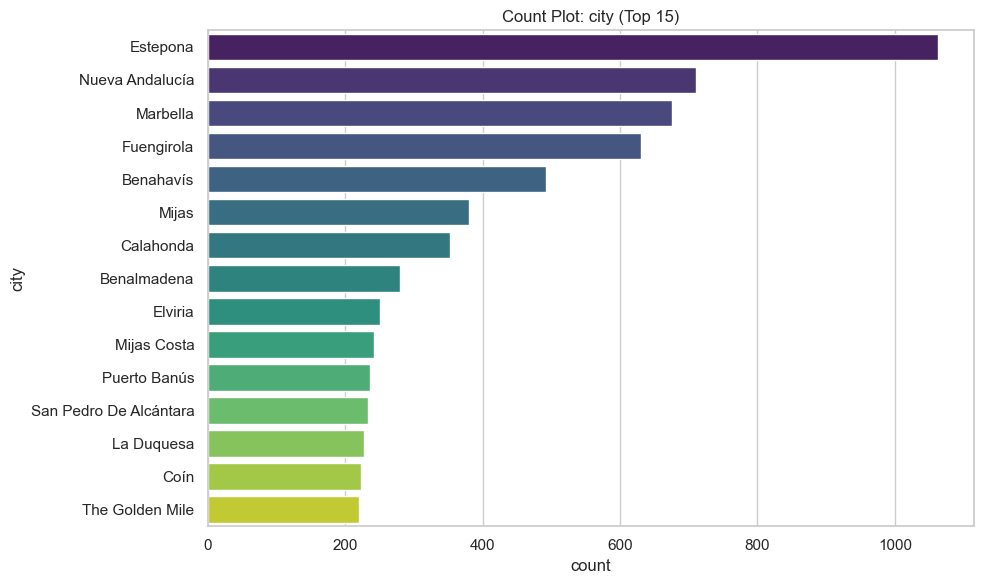

/tmp/ipykernel_45039/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


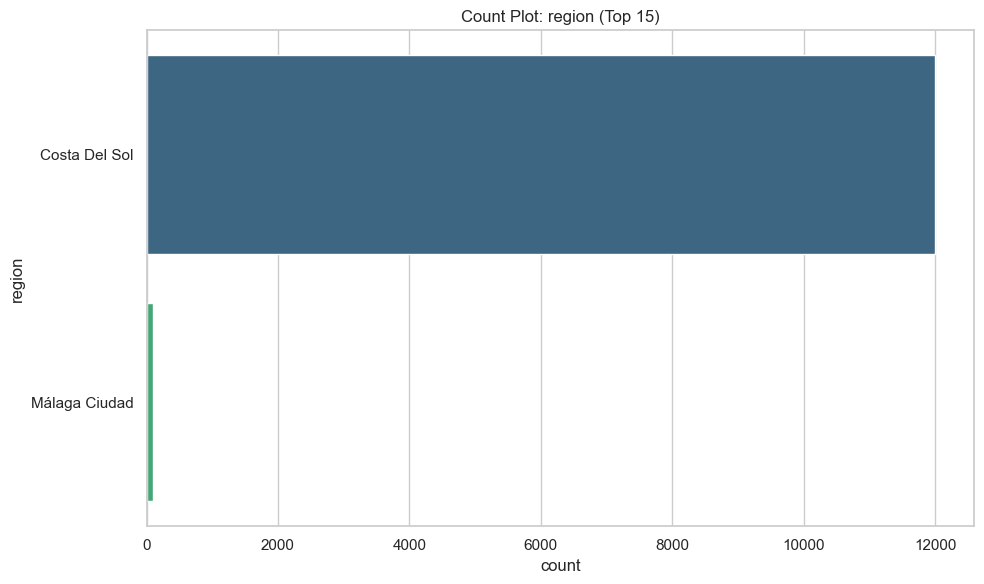

/tmp/ipykernel_45039/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


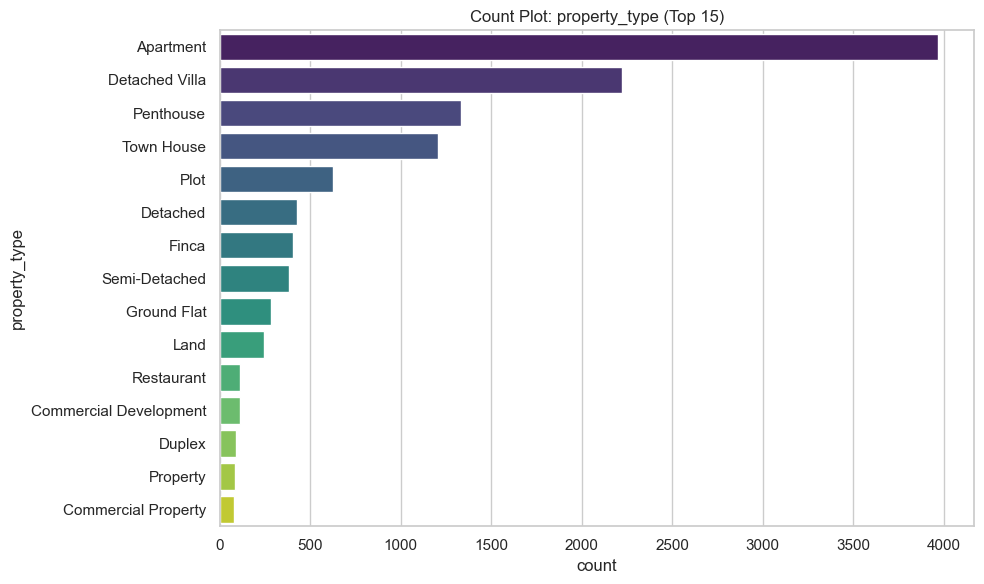


Generating Binary Feature Prevalence...


/tmp/ipykernel_45039/3323983233.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=binary_sums.values, y=binary_sums.index, palette='viridis')


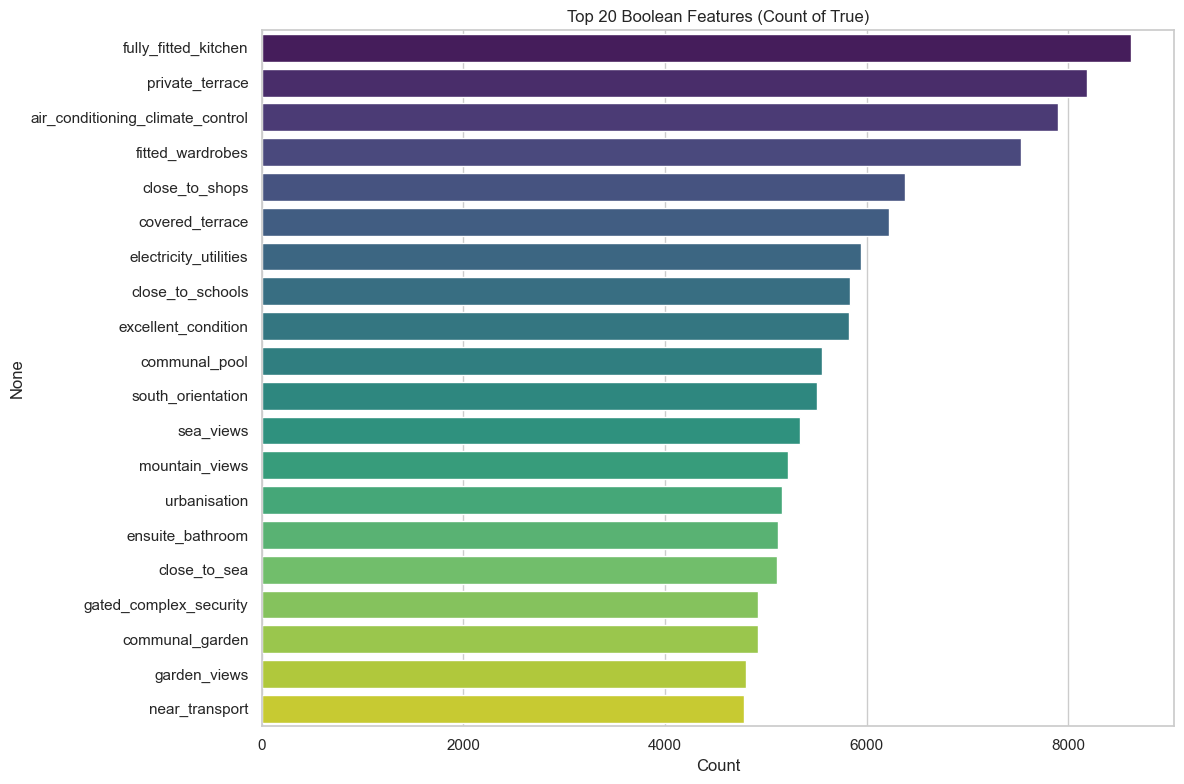

In [79]:
# --- Pairplot for ALL Continuous Variables ---
print("Generating pairplot for all continuous variables...")
sns.pairplot(df[continuousFeatures].dropna(), aspect=1.5, diag_kind='kde')
plt.suptitle('Pairplot of All Continuous Variables', y=1.02, fontsize=16)
plt.savefig('images/pairplot_all.png')
plt.show()
# --- B. Count Plots (Main Categorical) ---
print("\nGenerating Count Plots for Main Categories...")
for col in categoricalFeatures:
    plt.figure(figsize=(10, 6))
    # Top 15 categories only to prevent clutter
    top_cats = df[col].value_counts().nlargest(15).index
    sns.countplot(y=col, data=df, order=top_cats, palette='viridis')
    plt.title(f'Count Plot: {col} (Top 15)')
    plt.tight_layout()
    plt.savefig(f'images/countplot_{col}.pdf')
    plt.show()

# --- C. Feature Prevalence Plot (All Binaries) ---
print("\nGenerating Binary Feature Prevalence...")
# Summing boolean True values works like counting 1s
binary_sums = df[binaryFeatures].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=binary_sums.values, y=binary_sums.index, palette='viridis')
plt.title('Top 20 Boolean Features (Count of True)')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('images/binary_prevalence.pdf')
plt.show()


### Correlation Matrix

Covariance Matrix:


,price,bedrooms,bathrooms,indoor_surface,outdoor_surface
price,3.539282e+12,1.617749e+10,1.559039e+10,3.447684e+08,7.680312e+10
bedrooms,1.617749e+10,9.708442e+09,4.182144e+06,3.705881e+02,1.999662e+04
bathrooms,1.559039e+10,4.182144e+06,2.149698e+09,3.710090e+02,2.134321e+04
indoor_surface,3.447684e+08,3.705881e+02,3.710090e+02,7.025941e+04,7.401787e+06
outdoor_surface,7.680312e+10,1.999662e+04,2.134321e+04,7.401787e+06,3.844150e+10




Calculating Pearson's Correlation...


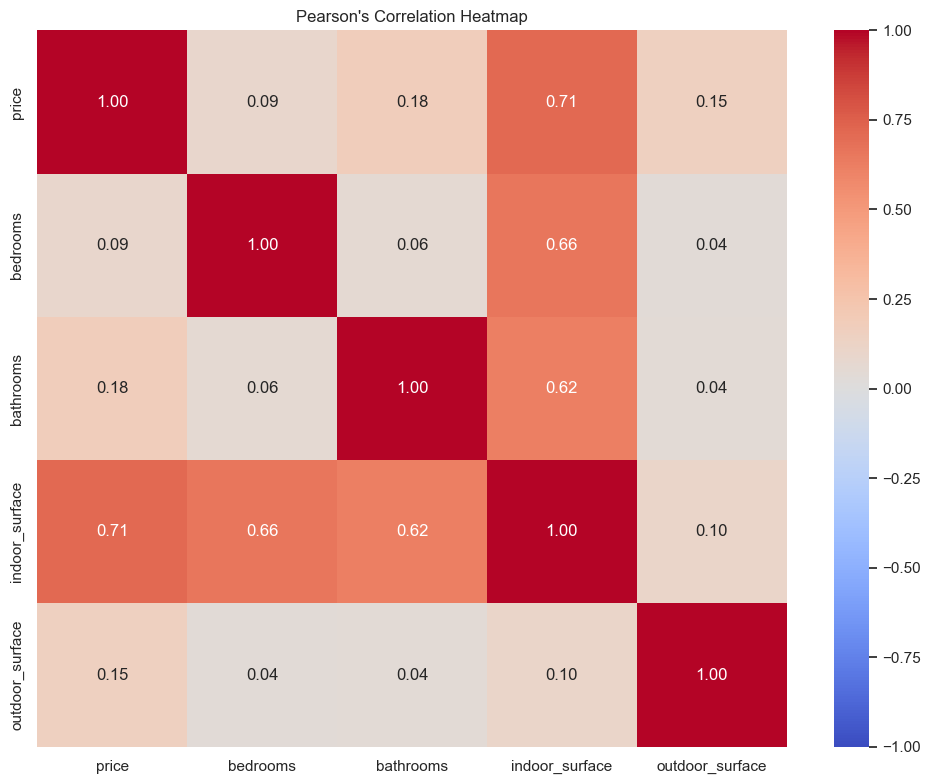

Calculating Spearman's Correlation...


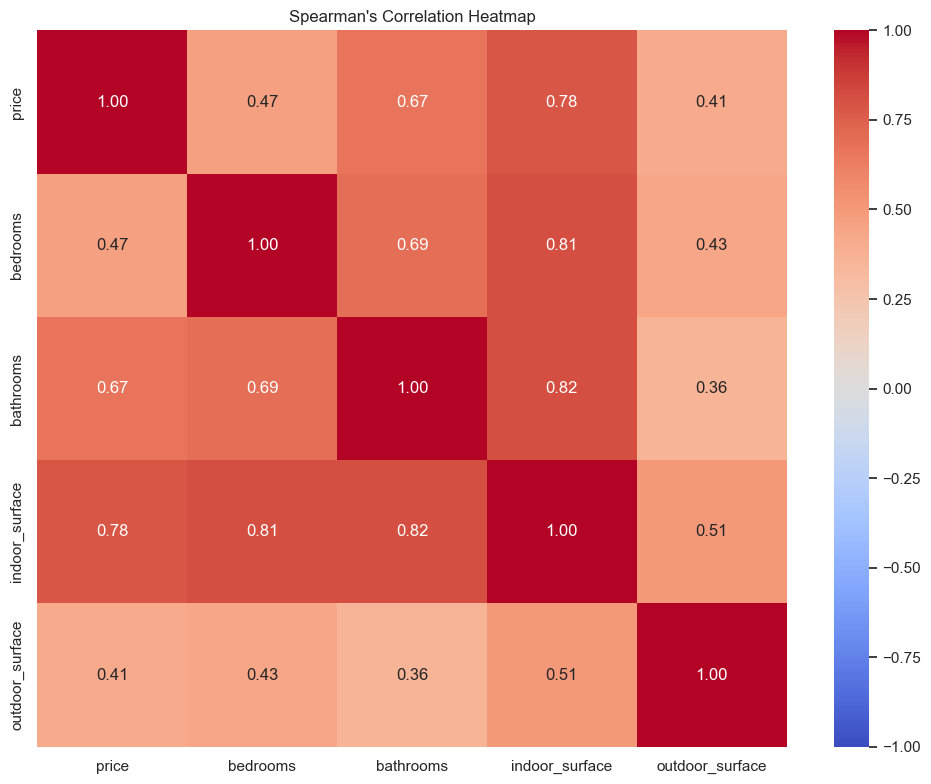

In [21]:
print("Covariance Matrix:")
covariance = df[continuousFeatures].cov()
display(covariance)
print("\n" + "="*80 + "\n") 

# --- Pearson's Correlation ---
print("Calculating Pearson's Correlation...")
plt.figure(figsize=(10, 8))
correlation = df[continuousFeatures].corr(method='pearson')
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pearson's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/pearson_correlation.pdf')
plt.show()

# --- Spearman's Correlation ---
print("Calculating Spearman's Correlation...")
plt.figure(figsize=(10, 8))
correlationSp = df[continuousFeatures].corr(method='spearman')
sns.heatmap(correlationSp, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Spearman's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/spearman_correlation.pdf')
plt.show()

### More detailed


Generating Pearson Correlation Matrix...


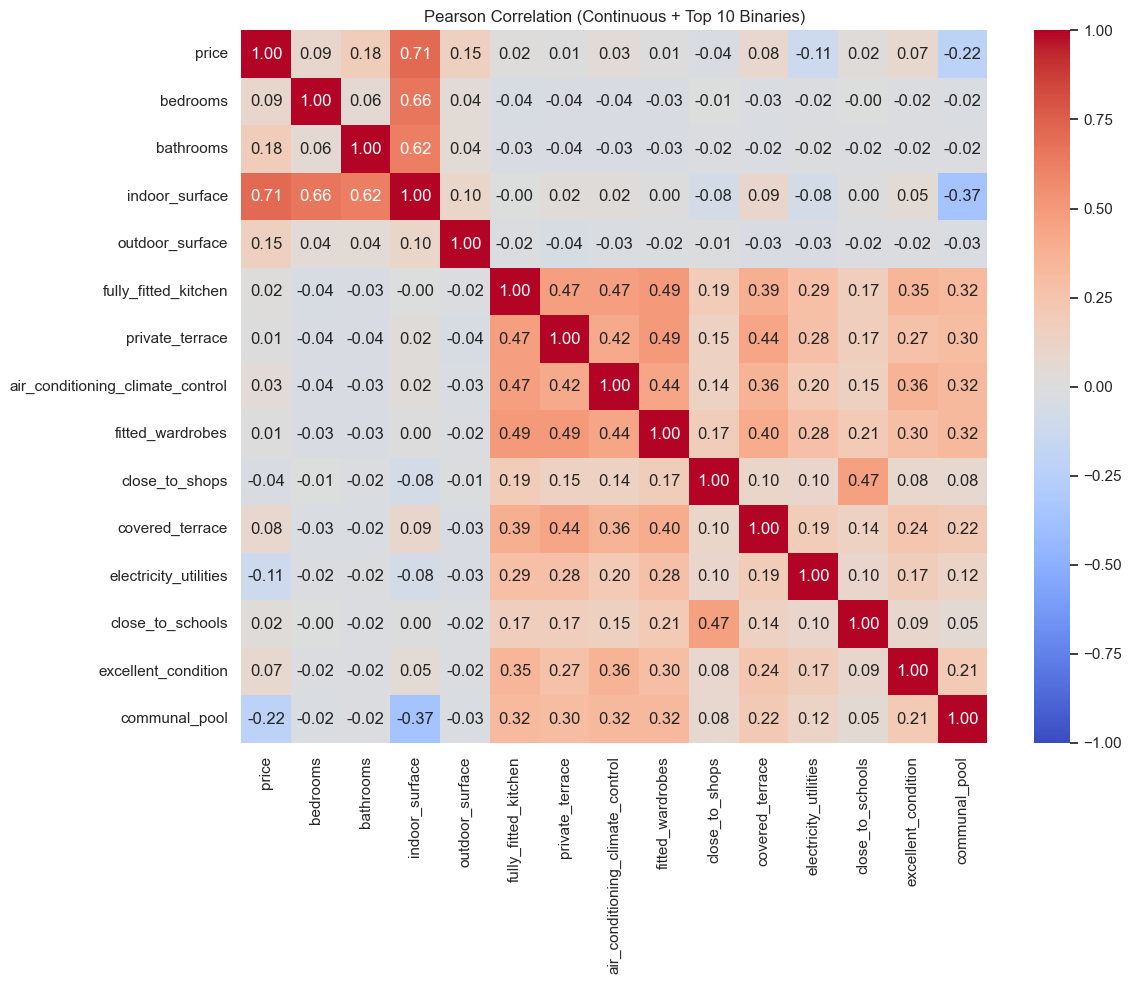


Generating Spearman Correlation Matrix...


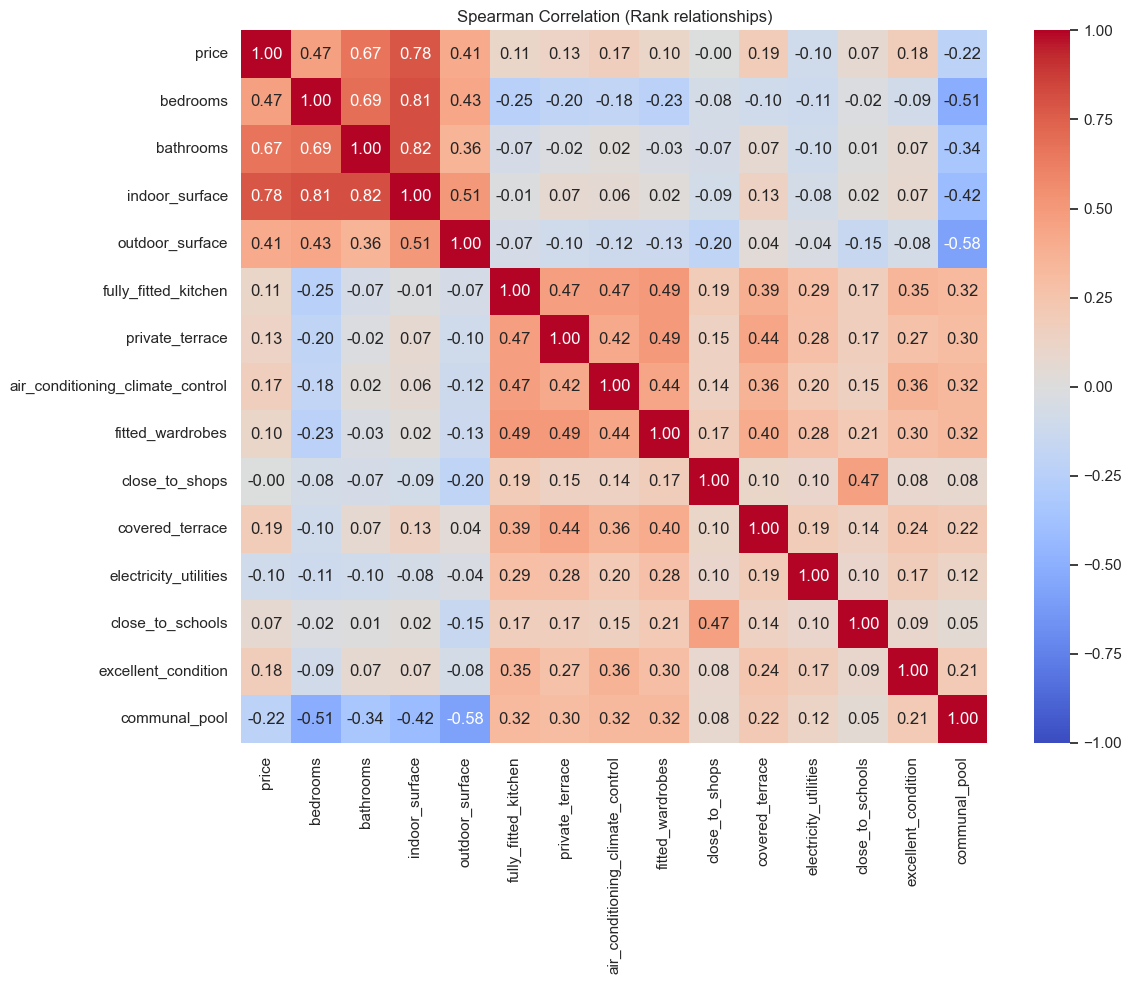

In [81]:
# Prepare data for correlation:
# We must convert booleans to integers (0/1) specifically for the correlation matrix calculation,
# otherwise .corr() might ignore them depending on pandas version.
corr_df = df[continuousFeatures].copy()
# Add top 10 binary features to correlation matrix for relevance
top_binaries = df[binaryFeatures].sum().sort_values(ascending=False).head(10).index
for col in top_binaries:
    corr_df[col] = df[col].astype(int)

# 1. Pearson
print("\nGenerating Pearson Correlation Matrix...")
plt.figure(figsize=(12, 10))
pearson_corr = corr_df.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson Correlation (Continuous + Top 10 Binaries)")
plt.tight_layout()
plt.savefig('images/correlation_pearson.pdf')
plt.show()

# 2. Spearman
print("\nGenerating Spearman Correlation Matrix...")
plt.figure(figsize=(12, 10))
spearman_corr = corr_df.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman Correlation (Rank relationships)")
plt.tight_layout()
plt.savefig('images/correlation_spearman.pdf')
plt.show()

In [82]:
# --- G. High Correlation Analysis (Target: Price) ---
print("\n" + "="*30 + " HIGH CORRELATION ANALYSIS " + "="*30)

# 1. Prepare Data: Combine Continuous and Binary (converted to int)
# Note: We use .corrwith to check correlation specifically against 'price' efficiently
analysis_df = df[continuousFeatures].copy()
# Add binary features as integers (0/1) so they can be correlated
analysis_df = pd.concat([analysis_df, df[binaryFeatures].astype(int)], axis=1)

# 2. Calculate Correlation with Price
price_correlations = analysis_df.corrwith(analysis_df['price'])

# 3. Filter for Absolute Correlation > 0.5
# We drop 'price' itself as it will always be 1.0
high_corr_features = price_correlations[abs(price_correlations) > 0.5].drop('price', errors='ignore')
high_corr_features = high_corr_features.sort_values(ascending=False)

print("Features with Absolute Correlation > 0.5 with Price:")
if not high_corr_features.empty:
    display(high_corr_features.to_frame(name='Correlation Coefficient'))
else:
    print("No features found with correlation > 0.5.")


============================== HIGH CORRELATION ANALYSIS ==============================
Features with Absolute Correlation > 0.5 with Price:


,Correlation Coefficient
indoor_surface,0.712566


# Data Prep